# TABULAR PLAYGROUND SERIES (MARCH 2022)

## OBJECTIVE

The objective of this notebook is to forecast the twelve-hours of traffic flow in a major U.S. metropolitan area, based on the data provided for the Tabular Playground Series for March 2022. The dependent variable in this study refers to the congestion of the traffic, and is a numeric variable.

Hence, we will be using linear regression in this exercise.

### Step 1: Import Library

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


### Step 2: Import Data 

In [2]:
Train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/train.csv')
Test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/test.csv')

### Step 3: Preliminary Data Visualisation & EDA

Taking a look at the train data set, we find 4 possible explanatory variables that might affect our response variable (congestion):
1.     time
2.     x
3.     y
4.     direction

We also checked to make sure no missing variables in both our train and test dataset, and find out the data types of our train data

In [3]:
Train.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [4]:
print(Train.isnull().sum(),Test.isnull().sum())

row_id        0
time          0
x             0
y             0
direction     0
congestion    0
dtype: int64 row_id       0
time         0
x            0
y            0
direction    0
dtype: int64


There appears to be no missing values in our variables. Lets look at the types of data in our dataset. 

In [5]:
Train.dtypes

row_id         int64
time          object
x              int64
y              int64
direction     object
congestion     int64
dtype: object

We find that time is an 'object' variable, which we will have to convert to data time object. We then extract from the data information on whether the day falls on a weekend or weekday, to take into account possibility of it affecting the congestion. Next, we extract out the time of the day (in 20 mins time block) and store it in the column name "time-block". We also create a new column to combine the x and y coordinates and name it "coord". 

In [6]:
Train['time'] = pd.to_datetime(Train['time'])
Train['day'] = pd.to_datetime(Train['time']).dt.dayofweek
Train['hour'] = Train.time.dt.hour
Train['weekday'] = np.where(Train['day'] < 5,0,1)
Train['time-block'] = Train['time'].dt.time
Train['time-block'] = Train['time-block'].astype('str')
Train['coord'] = Train['x'].astype(str) + ', ' + Train['y'].astype(str)
Train['coord'] = Train['coord'].astype(object)
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   row_id      848835 non-null  int64         
 1   time        848835 non-null  datetime64[ns]
 2   x           848835 non-null  int64         
 3   y           848835 non-null  int64         
 4   direction   848835 non-null  object        
 5   congestion  848835 non-null  int64         
 6   day         848835 non-null  int64         
 7   hour        848835 non-null  int64         
 8   weekday     848835 non-null  int64         
 9   time-block  848835 non-null  object        
 10  coord       848835 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 71.2+ MB


We then visualize our data using a few graphs:
1. Histogram of our response variable (congestion)
2. Plotting histogram of congestion against time(measured by hour) segmented by weekdays and weekends to see the effect of weekend on the congestion
3. Plotting histogram of congestion 

array([[<AxesSubplot:title={'center':'congestion'}>]], dtype=object)

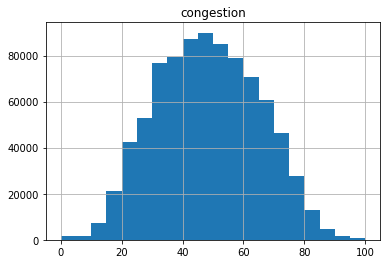

In [7]:
Train.hist(column = 'congestion', bins = 20)

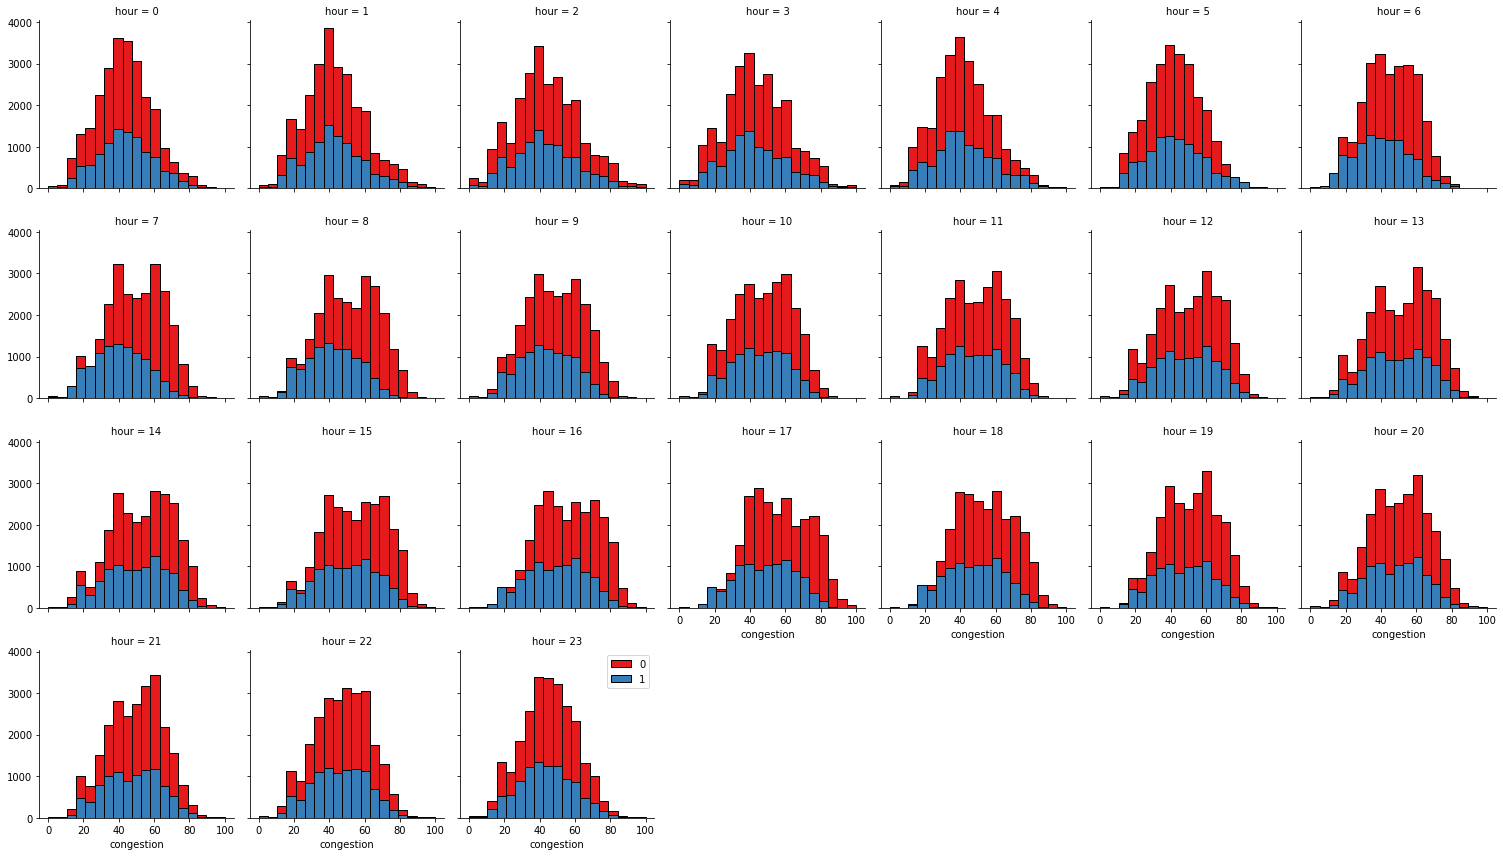

Note that 0 denotes a weekday and 1 denotes a weekend. From the graph, it appears that the distribution of congestion does not appear to differ much over the weekday and weekend.


In [8]:
bins = np.linspace(Train.congestion.min(), Train.congestion.max(), 20)
g = sns.FacetGrid(Train, col = "hour", hue="weekday", palette = "Set1", col_wrap = 7)
g.map(plt.hist, 'congestion', bins = bins, ec = "k")

g.axes[-1].legend()
plt.show()
print("Note that 0 denotes a weekday and 1 denotes a weekend. From the graph, it appears that the distribution of congestion does not appear to differ much over the weekday and weekend.")

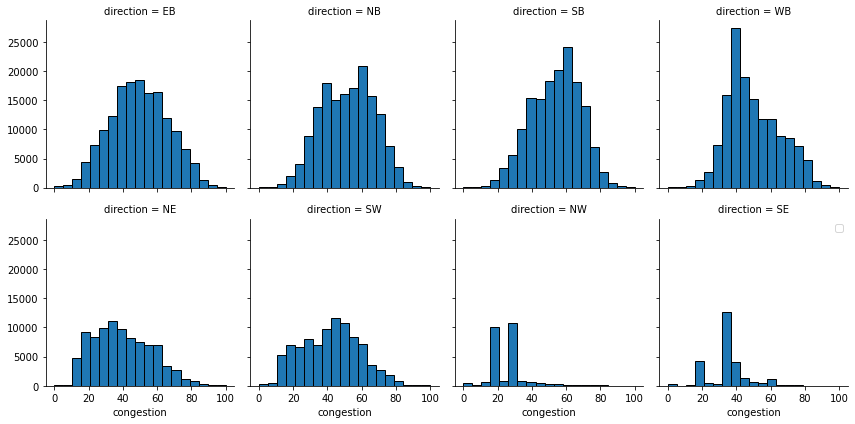

In [9]:
bins = np.linspace(Train.congestion.min(), Train.congestion.max(), 20)
g = sns.FacetGrid(Train, col = "direction", palette = "Set1", col_wrap = 4)
g.map(plt.hist, 'congestion', bins = bins, ec = "k")

g.axes[-1].legend()
plt.show()

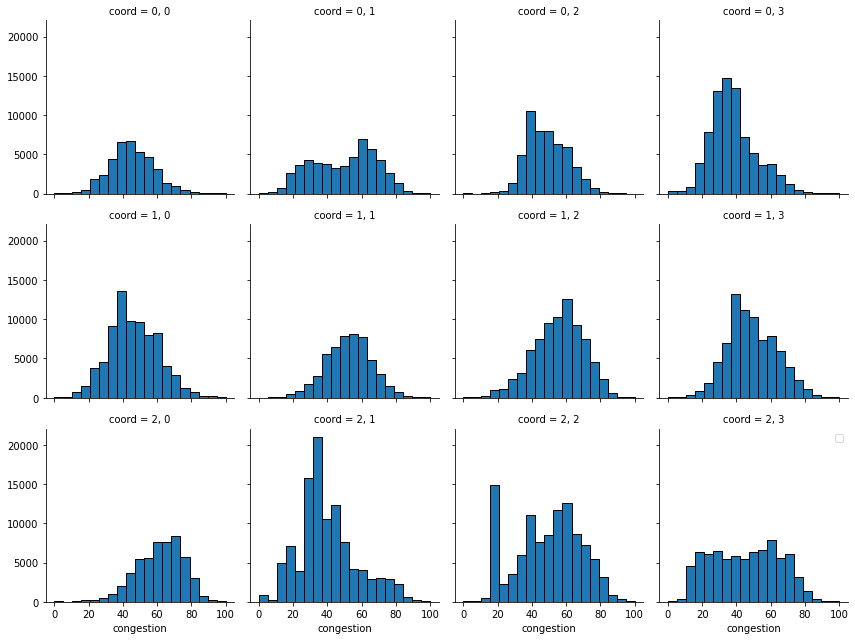

In [10]:
bins = np.linspace(Train.congestion.min(), Train.congestion.max(), 20)
g = sns.FacetGrid(Train, col = "coord", palette = "Set1", col_wrap = 4)
g.map(plt.hist, 'congestion', bins = bins, ec = "k")

g.axes[-1].legend()
plt.show()

### Step 4: Predictive Modelling

First, let's take a look at our dataset again.

In [11]:
Train.sort_values(by = ['direction','coord','time'], axis=0, ascending=True, inplace=True)
Train.head(20)

,row_id,time,x,y,direction,congestion,day,hour,weekday,time-block,coord
0,0,1991-04-01 00:00:00,0,0,EB,70,0,0,0,00:00:00,"0, 0"
65,65,1991-04-01 00:20:00,0,0,EB,70,0,0,0,00:20:00,"0, 0"
130,130,1991-04-01 00:40:00,0,0,EB,70,0,0,0,00:40:00,"0, 0"
195,195,1991-04-01 01:00:00,0,0,EB,70,0,1,0,01:00:00,"0, 0"
260,260,1991-04-01 01:20:00,0,0,EB,70,0,1,0,01:20:00,"0, 0"
325,325,1991-04-01 01:40:00,0,0,EB,70,0,1,0,01:40:00,"0, 0"
390,390,1991-04-01 02:00:00,0,0,EB,70,0,2,0,02:00:00,"0, 0"
455,455,1991-04-01 02:20:00,0,0,EB,70,0,2,0,02:20:00,"0, 0"
520,520,1991-04-01 02:40:00,0,0,EB,70,0,2,0,02:40:00,"0, 0"
585,585,1991-04-01 03:00:00,0,0,EB,70,0,3,0,03:00:00,"0, 0"


In [12]:
Test_1 = Train.drop(['row_id','x','y','hour','weekday','time-block'], axis=1)
Test_1 = pd.concat([Test_1,pd.get_dummies(Test_1['direction'])], axis=1) 
Test_1 = pd.concat([Test_1,pd.get_dummies(Test_1['coord'])], axis=1) 
Test_1.drop(['direction', 'coord','time'],axis = 1,inplace = True)

#### Check for Stationarity

In [13]:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen


# coint_johansen(Test_1, -1, 1).eig

Next, lets clean up our dataset to only include variables that we require:
* Direction (direction)
* Coordinates (Coord)
* Time (time-block)
* Day of the Week (day)

We will also be transforming our response variable, by square-rooting the value

In [14]:
Train_1 = Train
Train_1 = Train_1.drop(['row_id','x','y','hour','weekday','time'], axis=1)
Train_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   direction   848835 non-null  object
 1   congestion  848835 non-null  int64 
 2   day         848835 non-null  int64 
 3   time-block  848835 non-null  object
 4   coord       848835 non-null  object
dtypes: int64(2), object(3)
memory usage: 38.9+ MB


In [15]:
X_train = Train_1.drop(['congestion'], axis = 1)
# Train_1['cbrt_congestion'] = np.cbrt(Train_1['congestion'])
y_train = Train_1['congestion']

print(X_train.head())
print(y_train.head())

    direction  day time-block coord
0          EB    0   00:00:00  0, 0
65         EB    0   00:20:00  0, 0
130        EB    0   00:40:00  0, 0
195        EB    0   01:00:00  0, 0
260        EB    0   01:20:00  0, 0
0      70
65     70
130    70
195    70
260    70
Name: congestion, dtype: int64


We will need to scale our X variables for our model

In [16]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

#### Train-Test Splitting
Finally, we will be splitting our train and test data from our given Training Dataset, with a Test Size of 20%.

In [17]:
from sklearn.model_selection import train_test_split
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train, test_size = 0.2, random_state = 20220301)

#### Our Linear Model
In order to create our linear model for fitting of our train data, we will first have to convert our categorical variables to numeric. In order to create dummies to represent these categories, we will first employ One Hot Encoding. We then create a linear model by fiting our training data to represent the relation between our suggested dependent variables and congestion. 

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

Encode_features = Train_1.columns[Train_1.dtypes==object].tolist()
col_transform = make_column_transformer((OneHotEncoder(), Encode_features), remainder = "passthrough")

In [19]:
from sklearn import linear_model
LR = linear_model.LinearRegression()
# LR = linear_model.PoissonRegressor()
# GR = linear_model.LogisticRegression(solver='liblinear', max_iter=400)
# R = linear_model.Ridge()
Poly = preprocessing.PolynomialFeatures(degree=4)

In [20]:
from sklearn.pipeline import make_pipeline as pipe

EncPR = pipe(col_transform, Poly, LR)
EncPR.fit(X_subtrain, y_subtrain)
y_hat = (EncPR.predict(X_subtest))

In [21]:
# from statistics import mean
# SSR = sum((y_subtest - y_hat) ** 2)
# y_mean = mean(y_subtest)
# SST = sum((y_mean - y_subtest) ** 2)
# R2 = 1 - (SSR/SST)

import sklearn.metrics as metrics
R2=metrics.r2_score(y_subtest, y_hat)

print("The R-squared value of our linear model is ", R2)

The R-squared value of our linear model is  0.7102010603692248


### Step 5: Predicting Congestion using Test Data

First, we will transform our dependent varialbes in our Test Data to suit our linear model.

In [22]:
Test['time'] = pd.to_datetime(Test['time'])
Test['day'] = pd.to_datetime(Test['time']).dt.dayofweek
Test['time-block'] = Test['time'].dt.time
Test['time-block'] = Test['time-block'].astype('str')
Test['coord'] = Test['x'].astype(str) + ', ' + Test['y'].astype(str)
Test['coord'] = Test['coord'].astype(object)
Test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   row_id      2340 non-null   int64         
 1   time        2340 non-null   datetime64[ns]
 2   x           2340 non-null   int64         
 3   y           2340 non-null   int64         
 4   direction   2340 non-null   object        
 5   day         2340 non-null   int64         
 6   time-block  2340 non-null   object        
 7   coord       2340 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 146.4+ KB


In [23]:
Test_1 = Test
Test_1 = Test_1.drop(['row_id','x','y','time'], axis=1) 
Test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   direction   2340 non-null   object
 1   day         2340 non-null   int64 
 2   time-block  2340 non-null   object
 3   coord       2340 non-null   object
dtypes: int64(1), object(3)
memory usage: 73.2+ KB


In [24]:
y_predict = EncPR.predict(Test_1)
Test_congestion = Test.assign(congestion = y_predict)
Test_congestion.head()
submission = Test_congestion[['row_id', 'congestion']]
submission.head()
submission.to_csv('submission.csv', index=False)